In [2]:
from data.sampler import BalancedRandomBatchGeoSampler
from configs import config
from pathlib import Path
from torch.utils.data import DataLoader
from torchgeo.datasets import NAIP, stack_samples
from data.kc import KaneCounty


naip_dataset = NAIP("/net/projects/cmap/data/KC-images")

shape_path = Path(config.KC_SHAPE_ROOT) / config.KC_SHAPE_FILENAME
dataset_config = (
        config.KC_LAYER,
        config.KC_LABELS,
        config.PATCH_SIZE,
        naip_dataset.crs,
        naip_dataset.res,
    )
kc_dataset = KaneCounty(shape_path, dataset_config)
train_dataset = naip_dataset & kc_dataset

train_sampler = BalancedRandomBatchGeoSampler(
        config={
            "dataset": train_dataset,
            "size": config.PATCH_SIZE,
            "batch_size": 1,
        }
)

plot_dataloader = DataLoader(
        dataset=train_dataset,
        batch_sampler=train_sampler,
        collate_fn=stack_samples,
        num_workers=config.NUM_WORKERS,
)


In [3]:
for batch, sample in enumerate(plot_dataloader):
    print(sample['image'].shape, sample['mask'].shape)
    if batch > 2:
        break

torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 4, 512, 512]) torch.Size([1, 512, 512])


In [4]:
def display_plot_from_tensors(sample, colors, labels, coords):
    # Call the original function with a temporary file path
    temp_path = "temp_plot.png"
    from utils.plot import plot_from_tensors
    plot_from_tensors(
        sample=sample,
        save_path=temp_path,
        colors=colors,
        labels=labels,
        coords=coords
    )
    # Now display the saved image in the notebook
    from IPython.display import Image, display
    display(Image(filename=temp_path))

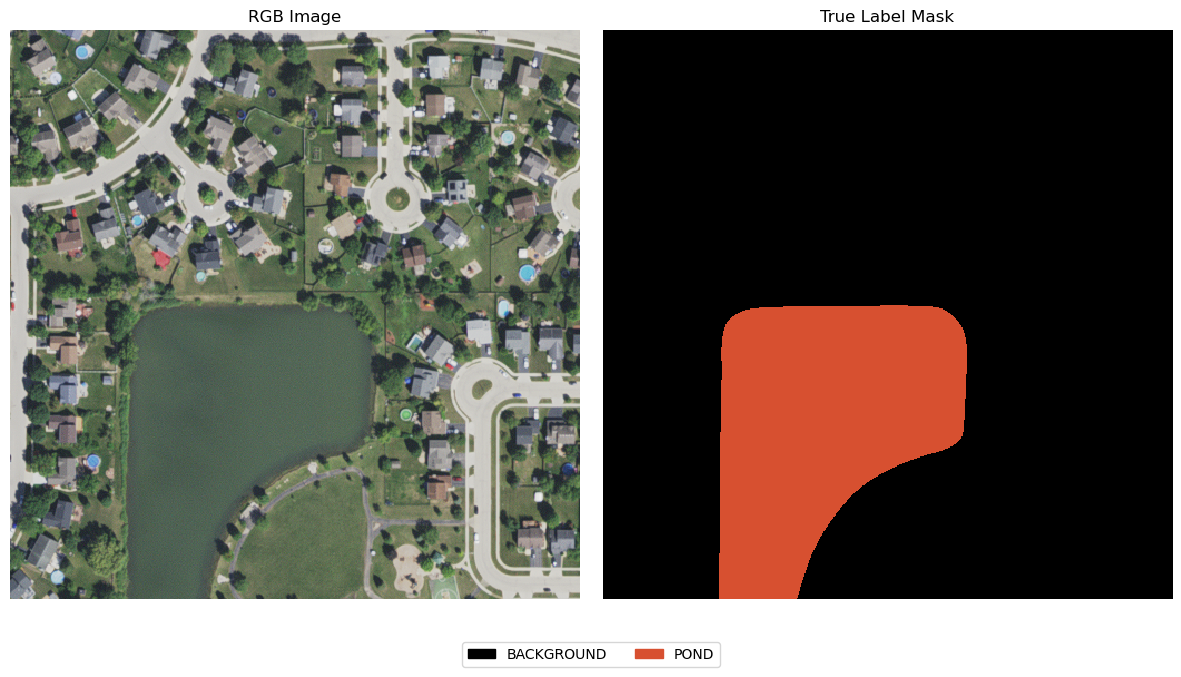

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from einops import rearrange
import torch
import numpy as np

# --- Create a custom colormap from kc_dataset.colors ---
# Sort the keys so that the colormap is consistent
sorted_keys = sorted(kc_dataset.colors.keys())
# Normalize the colors (RGB only) to [0,1]
color_list = [tuple(np.array(kc_dataset.colors[k][:3]) / 255.0) for k in sorted_keys]
custom_cmap = ListedColormap(color_list)

# --- Extract one sample from the dataloader ---
sample = next(iter(plot_dataloader))
img_tensor = sample['image'][0]  # shape: (channels, height, width)
mask_tensor = sample['mask'][0]  # shape: (height, width) or (1, height, width)

# Squeeze extra channel from mask if necessary
if mask_tensor.dim() == 3 and mask_tensor.shape[0] == 1:
    mask_tensor = mask_tensor.squeeze(0)

# Use only the first 3 channels for RGB visualization
img_rgb = img_tensor[:3] if img_tensor.shape[0] >= 3 else img_tensor

# Rearrange the image to (height, width, channels) and convert to NumPy uint8
img_rgb_np = rearrange(img_rgb, "c h w -> h w c").cpu().numpy().astype("uint8")
# Convert mask to NumPy array for plotting
mask_np = mask_tensor.cpu().numpy()

# Save the overlay for later use
overlay = mask_np.copy()

# --- Create two subplots: RGB Image & True Label Mask ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 1. Display RGB Image (No Mask Overlay)
axs[0].imshow(img_rgb_np, interpolation="none")
axs[0].set_title("RGB Image")
axs[0].axis("off")

# 2. Display True Label Mask (solid colors, no alpha blending)
axs[1].imshow(mask_np, cmap=custom_cmap, interpolation="none", vmin=0, vmax=len(sorted_keys) - 1)
axs[1].set_title("True Label Mask")
axs[1].axis("off")

# --- Create a legend for the True Label Mask ---
legend_handles = []
unique_vals_in_mask = set(np.unique(mask_np))  # Only include labels that appear in the image
for k in sorted_keys:
    if k in unique_vals_in_mask:
        label_name = kc_dataset.labels_inverse.get(k, str(k))
        color = tuple(np.array(kc_dataset.colors[k][:3]) / 255.0)
        patch = mpatches.Patch(color=color, label=label_name)
        legend_handles.append(patch)

# Add legend below the True Label Mask (only for present labels)
if legend_handles:
    fig.legend(handles=legend_handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()


In [6]:
import torch
import numpy as np

# Get unique values from the mask (excluding background)
unique_vals = torch.unique(mask_tensor)
valid_labels = unique_vals[unique_vals > 0]  # Exclude background (0)

if len(valid_labels) == 0:
    raise ValueError("No valid foreground labels found!")

# Find the label that has the **largest area** to avoid tiny regions
largest_label = None
max_size = 0

for label in valid_labels:
    size = (mask_tensor == label).sum().item()
    if size > max_size:
        max_size = size
        largest_label = label.item()

if largest_label is None:
    raise ValueError("No valid segmentation regions found!")

# Get **all** pixel coordinates where this label appears
ys, xs = torch.where(mask_tensor == largest_label)

if len(xs) > 0 and len(ys) > 0:
    # Pick a **random** point inside the largest label region
    random_index = torch.randint(0, len(xs), (1,)).item()
    seed_x = xs[random_index].item()
    seed_y = ys[random_index].item()

    # Store globally to ensure consistency across all cells
    global_seed_x = seed_x
    global_seed_y = seed_y

    print(f"Selected segmentation seed label: {largest_label}")
    print(f"Segmentation seed coordinate (global): (x={global_seed_x}, y={global_seed_y})")

    # Ensure the seed is actually inside the mask
    assert mask_tensor[global_seed_y, global_seed_x] == largest_label, "Seed point is NOT inside the labeled region!"

else:
    raise ValueError("Failed to select a valid segmentation seed!")


Selected segmentation seed label: 1
Segmentation seed coordinate (global): (x=113, y=386)


# Segmentation code:

In [7]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="/home/gregoryc25/CMAP/segment-anything/sam_vit_h.pth")
predictor = SamPredictor(sam)

Using **global** segmentation seed coordinate: (x=113, y=386)


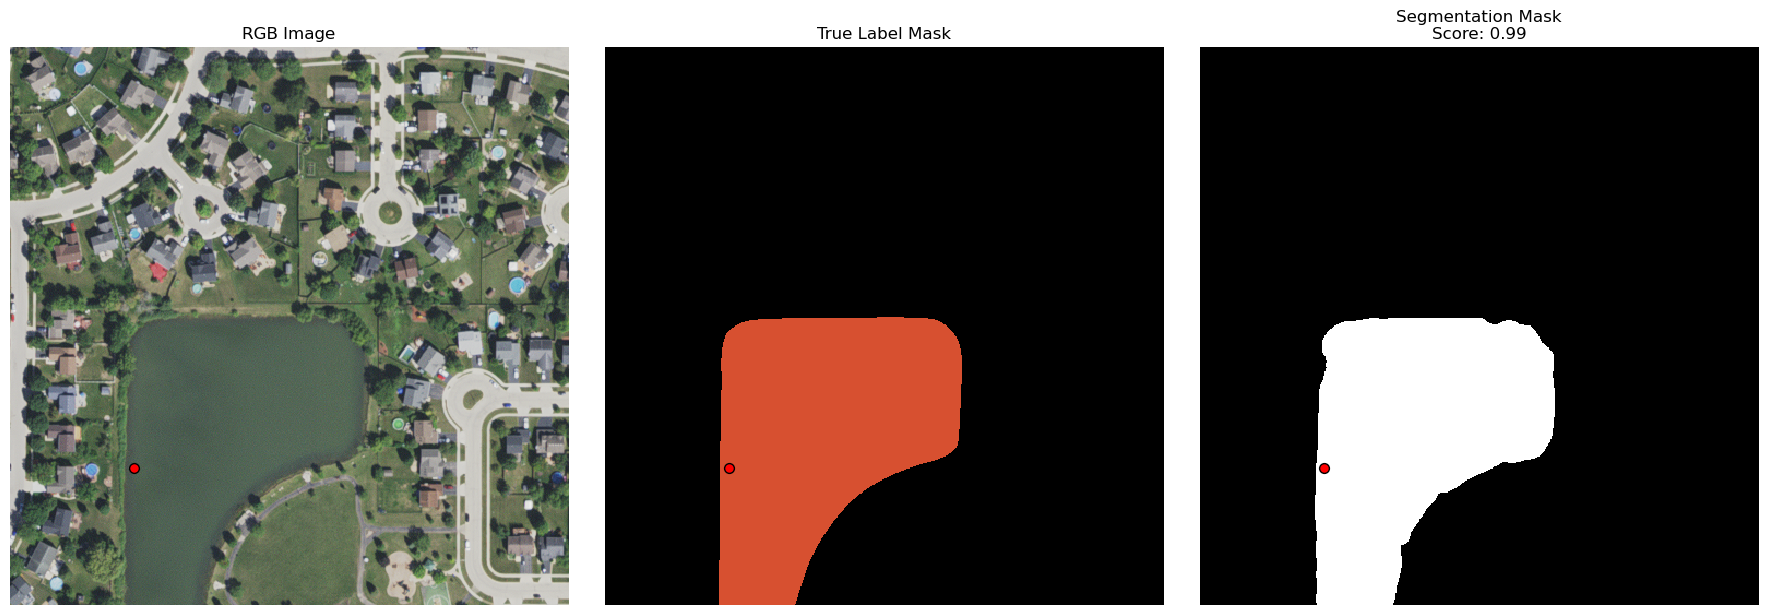

Saved segmentation result to: /home/gregoryc25/CMAP/segment-anything/kc-sam-outputs


In [8]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime

# Ensure we're using the same globally stored seed point
print(f"Using **global** segmentation seed coordinate: (x={global_seed_x}, y={global_seed_y})")

# Create the seed coordinate array in the expected shape (1, 2)
seed_coordinate = np.array([[global_seed_x, global_seed_y]])
seed_label = np.array([1])  # Positive prompt

# Set the image before predicting
predictor.set_image(img_rgb_np)

# --- Call the SAM predictor with the **same seed** ---
masks, scores, logits = predictor.predict(
    point_coords=seed_coordinate,
    point_labels=seed_label,
    multimask_output=False  # Single best mask
)

# Select the **highest scoring mask**
best_mask = masks[0]
best_score = scores[0]

# --- Create Three Subplots: RGB, True Label Mask, Segmentation Mask ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. Display RGB Image with Seed Point
axs[0].imshow(img_rgb_np, interpolation="none")
axs[0].scatter(global_seed_x, global_seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[0].set_title("RGB Image")
axs[0].axis("off")

# 2. Display True Label Mask with Seed Point (Solid Colors)
axs[1].imshow(mask_np, cmap=custom_cmap, interpolation="none", vmin=0, vmax=len(sorted_keys) - 1)
axs[1].scatter(global_seed_x, global_seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[1].set_title("True Label Mask")
axs[1].axis("off")

# 3. Display Best Segmentation Mask with Seed Point
axs[2].imshow(best_mask, cmap="gray", interpolation="none")
axs[2].scatter(global_seed_x, global_seed_y, color="red", s=50, marker="o", edgecolors="black")
axs[2].set_title(f"Segmentation Mask\nScore: {best_score:.2f}")
axs[2].axis("off")

# Define the output directory
output_folder = "/home/gregoryc25/CMAP/segment-anything/kc-sam-outputs"

# Ensure the folder exists
os.makedirs(output_folder, exist_ok=True)

# Generate a unique filename (timestamp-based)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = os.path.join(output_folder, f"segmentation_{timestamp}.png")

# Save the figure
plt.savefig(output_path, bbox_inches="tight", dpi=300)

plt.tight_layout()
plt.show()

print(f"Saved segmentation result to: {output_folder}")